In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import my_statistics as ms
import seaborn as sns
from sklearn import tree
from tqdm.notebook import tqdm
import copy
import decision_trees as dt
import random
import prettytable

In [2]:
hitters = pd.read_csv('Gradivo/Hitters.csv')

In [3]:
hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [4]:
hitters.shape

(322, 20)

In [5]:
hitters.dropna(axis=0, subset=['Salary'], inplace=True)

In [6]:
hitters.shape

(263, 20)

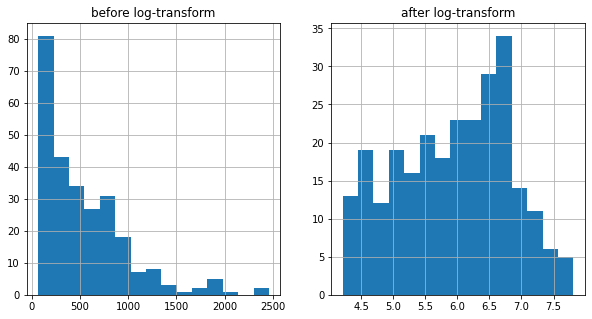

In [7]:
# salary log transform
salary_log = np.log(hitters.Salary)
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].hist(x = hitters.Salary, bins=15)
ax[0].set_title('before log-transform')
ax[0].grid()
ax[1].hist(x = salary_log, bins=15)
ax[1].set_title('after log-transform')
ax[1].grid()

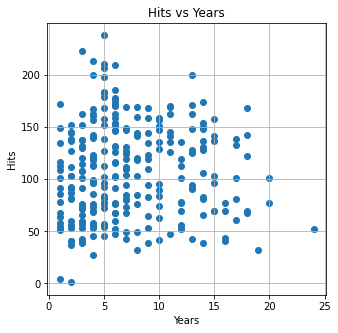

In [8]:
plt.figure(figsize=(5,5))
plt.scatter(hitters.Years, hitters.Hits)
plt.title('Hits vs Years')
plt.xlabel('Years')
plt.ylabel('Hits')
plt.grid()

###  Recursive binary splitting

In [9]:
hitters.head(1)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N


In [10]:
hitters_num = hitters.loc[:,hitters.dtypes == 'int64']

In [11]:
hitters_num.columns

Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists',
       'Errors'],
      dtype='object')

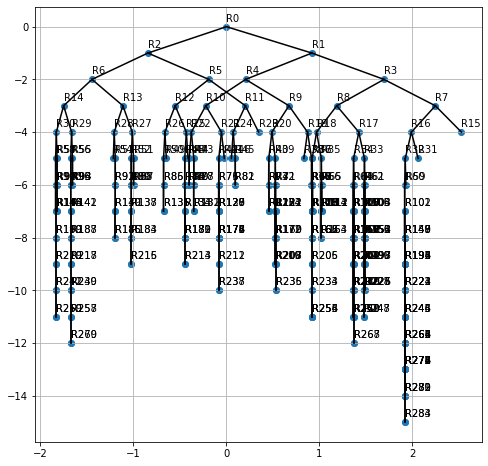

In [12]:
features = ['Hits', 'Runs', 'Walks', 'Years', 'RBI']
r_size=3
my_tree, y_ref_vals, y_classified, heritage = dt.decision_tree(hitters_num[features],
                                                               salary_log,
                                                               s_partitions=30,
                                                               R_size_max=r_size,
                                                               plot_ = True,
                                                               criterion = 'RSS')

In [13]:
pred, cl_pred = dt.predict(hitters_num[features], my_tree, y_ref_vals)

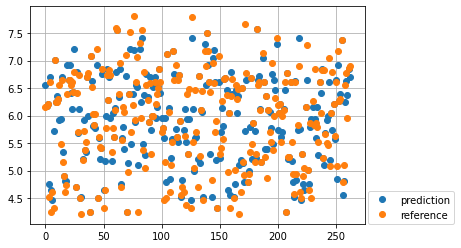

In [14]:
plt.plot(np.arange(len(pred)), pred,'o', label='prediction')
plt.plot(np.arange(len(pred)), salary_log,'o', label='reference')
plt.legend(loc=(1.01,0))
plt.grid()
#plt.xlim(0,50)

In [15]:
# predictions for different R size limits
features = ['Hits', 'Runs', 'Walks', 'Years', 'RBI']
errors, predictions, refs = {}, {}, {}
r_list = [50, 30, 10, 5, 3]
for r_size in tqdm(r_list):
    my_tree_r, y_ref_v_r, y_class_r, heritage_r = dt.decision_tree(hitters_num[features], salary_log,
                                                                   s_partitions=100, R_size_max=r_size,
                                                                  criterion='RSS')
    y_pred_r, y_cl_r = dt.predict(hitters_num[features], my_tree_r, y_ref_v_r)
    dif = abs(salary_log - y_pred_r)
    errors[r_size] = dif
    predictions[r_size] = y_pred_r
    refs[r_size] = np.array(salary_log)

  0%|          | 0/5 [00:00<?, ?it/s]

Text(0, 0.5, 'MSE')

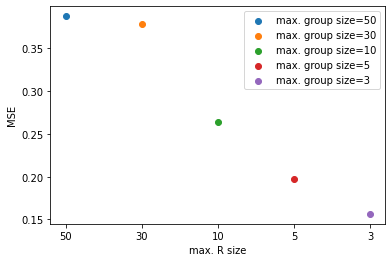

In [16]:
# MSE for different R size limits
for i,j in enumerate(r_list):
    plt.scatter(i, ms.MSE(np.array(predictions[j]), np.array(refs[j])),
                label=f'max. group size={j}')
plt.xticks(np.arange(len(r_list)), r_list)
plt.legend()
plt.xlabel('max. R size')
plt.ylabel('MSE')

(0.0, 100.0)

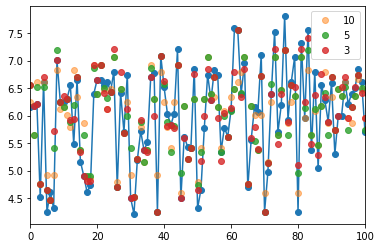

In [17]:
# predictions for different R sizes
plt.plot(np.arange(len(refs[50])), refs[50],'-o')
#plt.plot(np.arange(len(predictions[50])), predictions[50],'o', label=50)
#plt.plot(np.arange(len(predictions[30])), predictions[30], 'o', label=30,alpha=.5)
plt.plot(np.arange(len(predictions[10])), predictions[10], 'o', label=10, alpha=.5)
plt.plot(np.arange(len(predictions[5])), predictions[5], 'o', label=5, alpha=.8)
plt.plot(np.arange(len(predictions[3])), predictions[3], 'o', label=3, alpha=.8)
plt.legend()
plt.xlim(0,100)

### Determining $\alpha$ values and treesizes for tree pruning purpuses

In [18]:
tree_scores_alpha = []
alpha_l = []
tree_sizes_l = []
alpha_array = np.linspace(0,0.5,10)
for alpha in tqdm(alpha_array):
    tree_scores, tree_sizes = dt.tree_pruning(y_classified, y_ref_vals, heritage, 
                                              criterion = 'RSS',alpha=alpha, all_=True)
    alpha_l.append(alpha)
    tree_scores_alpha.append(tree_scores)
    tree_sizes_l.append(tree_sizes)

  0%|          | 0/10 [00:00<?, ?it/s]

α_0; tree score min = 41.471110302678454, tree size = 143
α_1; tree score min = 49.4155547471229, tree size = 143
α_2; tree score min = 57.35999919156734, tree size = 143
α_3; tree score min = 65.26797604491601, tree size = 142
α_4; tree score min = 73.12860534892049, tree size = 141
α_5; tree score min = 80.68977539176439, tree size = 135
α_6; tree score min = 88.18977539176439, tree size = 135
α_7; tree score min = 91.57556075362325, tree size = 25
α_8; tree score min = 92.85252411010605, tree size = 16
α_9; tree score min = 93.74141299899493, tree size = 16


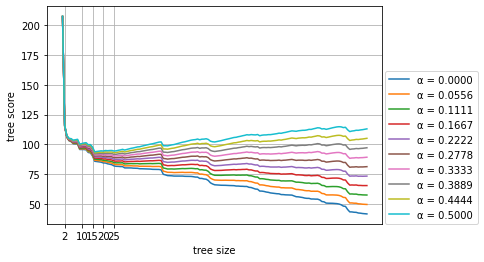

In [19]:
for i,j in enumerate(alpha_l):
    plt.plot(tree_sizes_l[i], tree_scores_alpha[i], label=f'α = {j:.4f}')
    min_ind = np.argmin(tree_scores_alpha[i])
    print(f'α_{i}; tree score min = {tree_scores_alpha[i][min_ind]}, tree size = {tree_sizes_l[i][min_ind]}')
plt.legend(loc = (1.01, 0))
plt.ylabel('tree score')
plt.xlabel('tree size')
plt.xticks(ticks=[2,10,15,20,25])
plt.grid()

In [20]:
# find alphas and corresponding tree sizes
alphas, sizes = dt.find_alphas(y_classified, y_ref_vals, heritage, np.linspace(0,0.5,10),
                              criterion='RSS')

  0%|          | 0/10 [00:00<?, ?it/s]

In [21]:
# k-fold CV
features = ['Hits', 'Runs', 'Walks', 'Years', 'RBI']
r_size=3
errors =  dt.k_fold_CV_for_decision_tree_pruning(hitters_num[features], 
                                                 salary_log, k=5,
                                                 alpha=alphas,
                                                 sizes=sizes, r_size=r_size,
                                                 criterion='RSS')

Main loop:   0%|          | 0/6 [00:00<?, ?it/s]

loop for α = 0.0:   0%|          | 0/5 [00:00<?, ?it/s]

loop for α = 0.1667:   0%|          | 0/5 [00:00<?, ?it/s]

loop for α = 0.2222:   0%|          | 0/5 [00:00<?, ?it/s]

loop for α = 0.2778:   0%|          | 0/5 [00:00<?, ?it/s]

loop for α = 0.3889:   0%|          | 0/5 [00:00<?, ?it/s]

loop for α = 0.4444:   0%|          | 0/5 [00:00<?, ?it/s]

([<matplotlib.axis.XTick at 0x1f489a25340>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

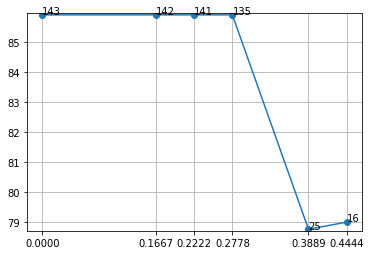

In [22]:
plt.plot(alphas, errors, '-o')
for i in range(len(alphas)):
    plt.annotate(sizes[i], (alphas[i], errors[i]+0.02))
plt.grid()
plt.ylim(min(errors)-0.05, max(errors)+0.05)
plt.xticks(alphas)

In [23]:
my_tree, y_ref_vals, y_classified, heritage = dt.decision_tree(hitters_num[features],
                                                            salary_log,
                                                            s_partitions=100,
                                                            R_size_max=r_size,
                                                           plot_ = False,
                                                              criterion='RSS')
my_tree, y_ref_vals = dt.shrink_tree(my_tree, y_classified, y_ref_vals,
                                     heritage, size_goal=sizes[4], criterion='RSS')
y_pred, cl_pred = dt.predict(hitters_num[features], my_tree, y_ref_vals)

In [24]:
y_pred.shape, hitters_num[features].shape

((263,), (263, 5))

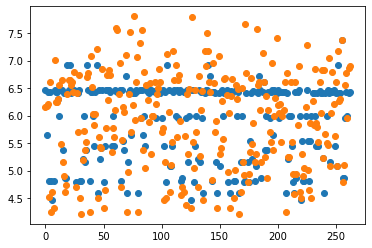

In [25]:
plt.plot(np.arange(len(y_pred)), y_pred,'o')
plt.plot(np.arange(len(y_pred)), salary_log,'o')
#plt.xlim(0,50)

##### Decision trees using sklearn

In [26]:
reg_tree = tree.DecisionTreeRegressor()

In [27]:
reg_tree_fit = reg_tree.fit(hitters_num, hitters.Salary)

In [28]:
sklearn_pred = reg_tree_fit.predict(hitters_num)

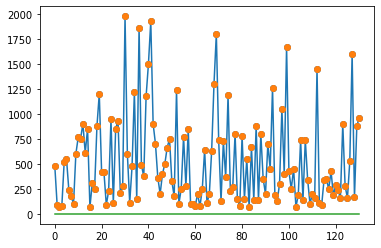

In [29]:
plt.plot(np.arange(131), reg_tree_fit.predict(hitters_num[1::2]),'-o')
plt.plot(np.arange(131),hitters.Salary[1::2],'o')
plt.plot(np.arange(131), reg_tree_fit.predict(hitters_num[1::2])- hitters.Salary[1::2])

In [30]:
(ms.MSE(np.array(predictions[50]), np.array(refs[50])),ms.MSE(np.array(predictions[30]), np.array(refs[30])),ms.MSE(np.array(predictions[10]), np.array(refs[10])))

(0.3876490343366689, 0.3780180940528448, 0.26410596315701235)

In [31]:
reg_tree_fit.predict(hitters_num[1::2]).shape

(131,)

In [32]:
hitters_num[1::2].shape

(131, 16)

In [33]:
hitters.Salary[1::2].shape

(131,)

### Classification Trees

In [34]:
h_df = pd.read_csv('Gradivo/Heart.csv')
h_df.drop(labels='Unnamed: 0', axis=1, inplace=True)

In [35]:
h_df.head()

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
1,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
2,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes
3,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,No
4,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,No


In [36]:
HD_dummy = np.zeros(h_df.shape[0])
HD_dummy[h_df.AHD == 'Yes'] = 1
HD_dummy[h_df.AHD == 'No'] = 0

In [37]:
h_df.shape[0]

303

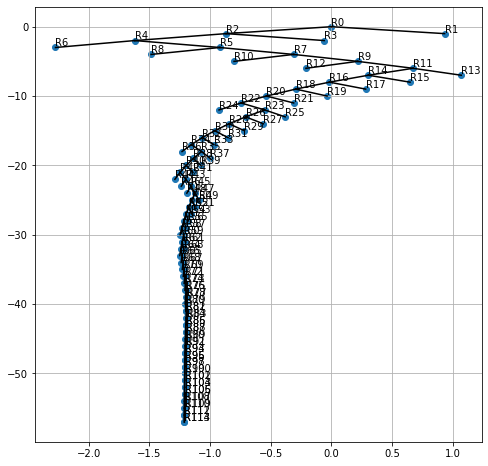

In [38]:
features = ['Age', 'Sex', 'RestBP', 'Chol', 'Fbs', 'RestECG', 'MaxHR',
            'ExAng', 'Oldpeak', 'Slope', 'Ca']
class_tree, y_cl_ref, y_cl_data, heritage_cl = dt.decision_tree(h_df[features][::2],
                                                                HD_dummy[::2],
                                                                s_partitions=30,
                                                                R_size_max=30,
                                                                criterion='Gini',
                                                                plot_=True)

In [39]:
h_df[::2].shape, h_df[1::2].shape

((152, 14), (151, 14))

In [40]:
# cunfusion matrix for seen data
y_cl_pred, y_cl = dt.predict(h_df[features][::2], class_tree, y_cl_ref)
ms.confusion_matrix(y_cl_pred, HD_dummy[::2], print_=True);
#plt.scatter(np.arange(len(y_cl_pred)),y_cl_pred)
#plt.scatter(np.arange(len(y_cl_pred)),HD_dummy[::2],alpha=.5)

+-------------+-----------------------+-----------------------+------+
| True status |           No          |          Yes          | Sums |
+-------------+-----------------------+-----------------------+------+
|  Prediciton |                       |                       |      |
|      No     |         TN = 75       |         FN = 8        |  83  |
|     Yes     |         FP = 5        |         TP = 64       |  69  |
|             | specificity = 93.75 % | sensitivity = 88.89 % |      |
|     Sums    |           83          |           72          | 152  |
+-------------+-----------------------+-----------------------+------+


In [41]:
# confusion matrix for unseen data
y_cl_pred, y_cl = dt.predict(h_df[features][1::2], class_tree, y_cl_ref)
ms.confusion_matrix(y_cl_pred, HD_dummy[1::2], print_=True);
#plt.scatter(np.arange(len(y_cl_pred)),y_cl_pred)
#plt.scatter(np.arange(len(y_cl_pred)),HD_dummy[1::2],alpha=.5)

+-------------+-----------------------+-----------------------+------+
| True status |           No          |          Yes          | Sums |
+-------------+-----------------------+-----------------------+------+
|  Prediciton |                       |                       |      |
|      No     |         TN = 54       |         FN = 24       |  78  |
|     Yes     |         FP = 30       |         TP = 43       |  73  |
|             | specificity = 64.29 % | sensitivity = 64.18 % |      |
|     Sums    |           78          |           67          | 151  |
+-------------+-----------------------+-----------------------+------+


In [42]:
tree_scores_alpha = []
alpha_l = []
tree_sizes_l = []
alpha_array = np.linspace(0,.8,20)
for alpha in tqdm(alpha_array):
    tree_scores, tree_sizes = dt.tree_pruning(y_cl_data, y_cl_ref, heritage_cl,
                                              alpha=alpha, all_=True, criterion='Gini')
    alpha_l.append(alpha)
    tree_scores_alpha.append(tree_scores)
    tree_sizes_l.append(tree_sizes)

  0%|          | 0/20 [00:00<?, ?it/s]

α_0; tree score min = 12.0, tree size = 58
α_1; tree score min = 14.442105263157895, tree size = 58
α_2; tree score min = 16.88421052631579, tree size = 58
α_3; tree score min = 19.326315789473686, tree size = 58
α_4; tree score min = 21.76842105263158, tree size = 58
α_5; tree score min = 24.210526315789473, tree size = 58
α_6; tree score min = 26.65263157894737, tree size = 58
α_7; tree score min = 29.094736842105263, tree size = 58
α_8; tree score min = 31.53684210526316, tree size = 58
α_9; tree score min = 33.97894736842105, tree size = 58
α_10; tree score min = 36.421052631578945, tree size = 58
α_11; tree score min = 38.863157894736844, tree size = 58
α_12; tree score min = 41.294736842105266, tree size = 56
α_13; tree score min = 43.65263157894737, tree size = 56
α_14; tree score min = 45.578947368421055, tree size = 40
α_15; tree score min = 47.26315789473684, tree size = 40
α_16; tree score min = 48.94736842105263, tree size = 40
α_17; tree score min = 50.631578947368425, tre

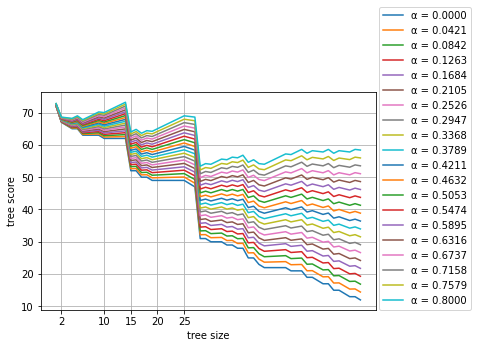

In [43]:
for i,j in enumerate(alpha_l):
    plt.plot(tree_sizes_l[i], tree_scores_alpha[i], label=f'α = {j:.4f}')
    min_ind = np.argmin(tree_scores_alpha[i])
    print(f'α_{i}; tree score min = {tree_scores_alpha[i][min_ind]}, tree size = {tree_sizes_l[i][min_ind]}')
plt.legend(loc = (1.01, 0))
plt.ylabel('tree score')
plt.xlabel('tree size')
plt.xticks(ticks=[2,10,15,20,25])
plt.grid()


In [44]:
# find alphas and corresponding tree sizes
alphas, sizes = dt.find_alphas(y_cl_data, y_cl_ref, heritage_cl, alpha_array, criterion='Gini')

  0%|          | 0/20 [00:00<?, ?it/s]

In [45]:
alphas, sizes

([0.0, 0.5052631578947369, 0.5894736842105263, 0.7578947368421053],
 [58, 56, 40, 28])

In [46]:
# k-fold CV
features = ['Age', 'Sex', 'RestBP', 'Chol', 'Fbs', 'RestECG', 'MaxHR',
            'ExAng', 'Oldpeak', 'Slope', 'Ca']
r_size=10
errors =  dt.k_fold_CV_for_decision_tree_pruning(h_df[features], 
                                                 HD_dummy, k=5,
                                                 alpha=alphas,
                                                 sizes=sizes, r_size=r_size,
                                                 criterion='gini')

Main loop:   0%|          | 0/4 [00:00<?, ?it/s]

loop for α = 0.0:   0%|          | 0/5 [00:00<?, ?it/s]

loop for α = 0.5053:   0%|          | 0/5 [00:00<?, ?it/s]

loop for α = 0.5895:   0%|          | 0/5 [00:00<?, ?it/s]

loop for α = 0.7579:   0%|          | 0/5 [00:00<?, ?it/s]

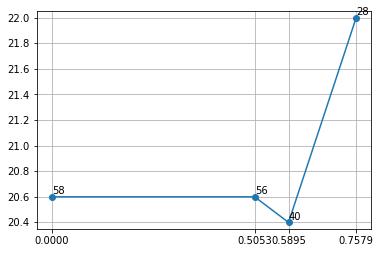

In [47]:
plt.plot(alphas, errors, '-o')
for i in range(len(alphas)):
    plt.annotate(sizes[i], (alphas[i], errors[i]+0.02));
plt.grid()
plt.ylim(min(errors)-0.05, max(errors)+0.05)
plt.xticks(alphas);

In [48]:
new_cl_tree, new_y_ref = dt.shrink_tree(class_tree, y_cl_data, y_cl_ref,
                                       heritage_cl, size_goal=25, 
                                        criterion='Gini')

In [49]:
# confusion matrix for unseen data
y_cl_pred, y_cl = dt.predict(h_df[features][1::2], new_cl_tree, new_y_ref)
print(y_cl_pred.shape, HD_dummy[1::2].shape)
ms.confusion_matrix(y_cl_pred, HD_dummy[1::2], print_=True);

(151,) (151,)
+-------------+-----------------------+-----------------------+------+
| True status |           No          |          Yes          | Sums |
+-------------+-----------------------+-----------------------+------+
|  Prediciton |                       |                       |      |
|      No     |         TN = 73       |         FN = 42       | 115  |
|     Yes     |         FP = 11       |         TP = 25       |  36  |
|             | specificity = 86.90 % | sensitivity = 37.31 % |      |
|     Sums    |          115          |           67          | 151  |
+-------------+-----------------------+-----------------------+------+


### Bagging

In [51]:
import decision_trees_class as dtc

In [67]:
b_ind = dtc.bootstrapping(1000,1000)

(0.0, 1001.0)

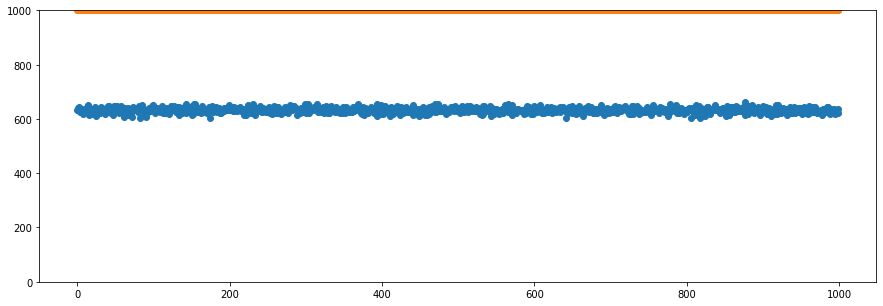

In [71]:
plt.figure(figsize=(15,5))
uniques = []
all_= []
for i in range(1000):
    uniques.append(len(np.unique(b_ind[i,:],return_counts=True)[0]))
    all_.append(1000)
plt.plot(uniques, 'o')
plt.plot(all_, 'o')
plt.ylim(0,1001)

In [72]:
di = {1:1, 2:2, 3:3, 4:4, 7:2, 5:2}

In [74]:
max(di.keys())

7